In [1]:
#Mounting google and authenticating
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

Mounted at /content/gdrive


In [2]:
!cp /mydrive/music\ project/X_spec.pickle ./
!cp /mydrive/music\ project/y_spec.pickle ./

In [3]:
#LOADING DATA
import pickle 
pickle_off = open("X_spec.pickle", 'rb')
X_spec = pickle.load(pickle_off)

pickle_off = open("y_spec.pickle", 'rb')
y_spec = pickle.load(pickle_off)

In [4]:
import numpy as np
dataset = np.vstack((X_spec,y_spec))
dataset = dataset.reshape(2862,300,128,1)

dataset.shape

(2862, 300, 128, 1)

In [14]:
test = dataset[:287]
train = dataset[287:]
print(train.shape)
print(test.shape)

(2575, 300, 128, 1)
(287, 300, 128, 1)


In [ ]:
train.shape

In [7]:
# For visual
import matplotlib.pyplot as plt
import librosa
import librosa.display

genre_name = 'X_spec[1]'
print(train[1].T.shape, genre_name)
plt.figure(figsize=(10, 4))
librosa.display.specshow(train[1].T, y_axis='time', fmax=8000, x_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(str(genre_name))
plt.show()

genre_name = 'y_spec[1]'
print(train[1000].T.shape, genre_name)
plt.figure(figsize=(10, 4))
librosa.display.specshow(train[1000].T, y_axis='time', fmax=8000, x_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(str(genre_name))
plt.show()

In [17]:
#Normalization
train = train/100
test = test/100
train_size = 2575
batch_size = 32
test_size = 287

In [18]:
#Getting Data Ready
import tensorflow as tf

train_dataset = (tf.data.Dataset.from_tensor_slices(train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test)
                .shuffle(test_size).batch(batch_size))

In [182]:
x = tf.keras.layers.Input((300, 128, 1))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x.shape



TensorShape([None, 19, 8, 256])

In [177]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(4,)))
model.add(tf.keras.layers.Dense(units=18*12*256, activation=tf.nn.relu))
model.add(tf.keras.layers.Reshape(target_shape=(18, 12, 256)))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=3, strides=(2,1), 
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(2,1),
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(1,2), padding='same',
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same',))

model.output_shape

(None, 300, 128, 1)

In [178]:
model.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 55296)             276480    
_________________________________________________________________
reshape_65 (Reshape)         (None, 18, 12, 256)       0         
_________________________________________________________________
conv2d_transpose_248 (Conv2D (None, 37, 14, 256)       590080    
_________________________________________________________________
conv2d_transpose_249 (Conv2D (None, 75, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_250 (Conv2D (None, 75, 32, 128)       147584    
_________________________________________________________________
conv2d_transpose_251 (Conv2D (None, 150, 64, 64)       73792     
_________________________________________________________________
conv2d_transpose_252 (Conv2D (None, 300, 128, 32)    

In [118]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(300, 128, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=256, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=19*8*256, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(18, 12, 256)),
            tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=3, strides=(2,1), 
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(2,1),
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(1,2), padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [119]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [121]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 4

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [122]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
    plt.subplot(2, 2, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [126]:
assert batch_size >= num_examples_to_generate

for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  print(test_sample.shape)

(4, 300, 128, 1)


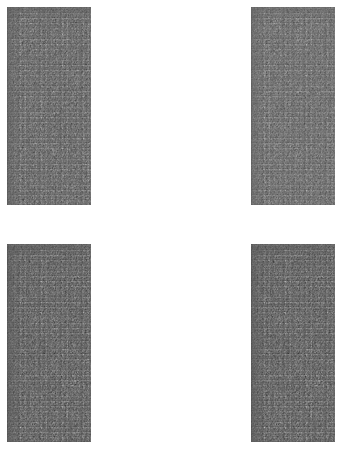

ValueError: ignored

In [128]:
import time

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)